### Project  |  Recommendation Systems


#### Import required libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import SVD

#### Load the data-set

In [2]:
df = pd.read_csv('ratings_Electronics.csv',names=['userId','productId','ratings','timestamp'])

#### EDA

In [3]:
print('Data-set has {} data-points and {} features'.format(df.shape[0],df.shape[1]))

Data-set has 7824482 data-points and 4 features


#### As the 'timestamp' are epoch time converting into human readable format

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')

In [5]:
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.0,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.0,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.0,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.0,2012-04-18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 238.8+ MB


#### Check for null values

In [7]:
df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [8]:
df.count()

userId       7824482
productId    7824482
ratings      7824482
timestamp    7824482
dtype: int64

###### Presence of null value is nil

### Understand total number of products that had been sold so far w.r.t ratings

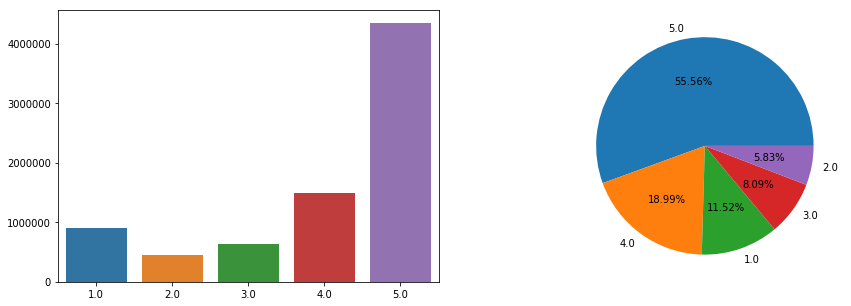

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

sns.barplot(df['ratings'].value_counts().index,df['ratings'].value_counts().values,ax=ax1)
ax2.pie(x=df['ratings'].value_counts().values, labels=df['ratings'].value_counts().index,autopct='%.2f%%')
plt.show()

In [10]:
df['ratings'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64

of total 7824482 products:

    4347541 products (which forms 55 % of total product) had been given 5 star rating
    1485781 products had been given 4 star rating
    633073 products had been given 3 star rating
    456322 products had been given 2 star rating
    901765 products had been given 1 star rating
    
    

### For the given year, understand the total number of products sold

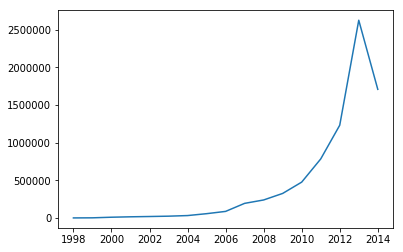

In [11]:
plt.plot(df.groupby(df.timestamp.dt.year)['productId'].count().index,
         df.groupby(df.timestamp.dt.year)['productId'].count().values)

plt.show()

From the above, it can infered that

* After the year 2006, product sales increased gradually
* After the year 2013 there was a dip in the sales

### For the given year, understand the number of products sold w.r.t ratings

In [12]:
df.groupby([df.timestamp.dt.year,'ratings']).count().sample(n=5)

,,userId,productId,timestamp
timestamp,ratings,,,
2004,1.0,6223,6223,6223
2001,5.0,7261,7261,7261
2010,2.0,30431,30431,30431
2002,5.0,8982,8982,8982
2008,4.0,52966,52966,52966


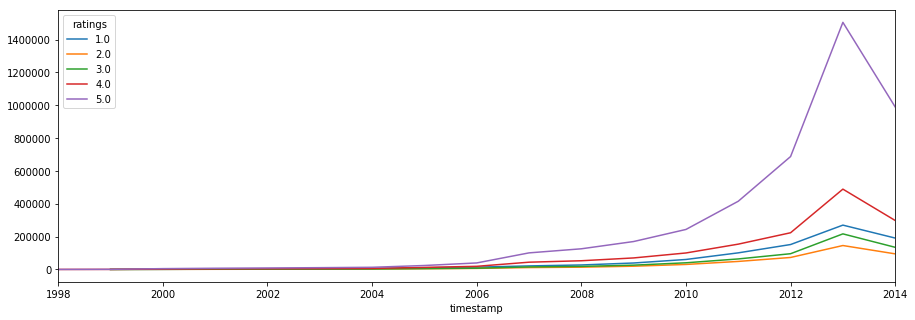

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
gby = df.groupby([df.timestamp.dt.year,'ratings'])['productId'].count()
gby.unstack().plot(ax=ax)
plt.show()

* At any given year it is a 5 star rating product that had been sold for a considerable amount, which resembles the pie chart data

### Popularity based recommendation model

In [14]:
# Drop the 'timestamp' column for recommendation model
df.drop(columns='timestamp',inplace=True)

In [15]:
print('number of unique product-ID in the given data-set are\t{}'.format(df['productId'].nunique()))

number of unique product-ID in the given data-set are	476002


In [16]:
pbrm_df = pd.DataFrame(df.groupby(['productId'])['ratings'].count().sort_index())
pbrm_df.rename(columns={"ratings":"ratings_count"},inplace=True)

In [17]:
pbrm_df['mean_ratings'] = df.groupby('productId')['ratings'].mean().sort_index()

In [18]:
pbrm_df.sort_values(by=['ratings_count','mean_ratings'], ascending=False).head(10)

,ratings_count,mean_ratings
productId,,
B0074BW614,18244,4.491504
B00DR0PDNE,16454,3.931020
B007WTAJTO,14172,4.424005
B0019EHU8G,12285,4.754497
B006GWO5WK,12226,4.314657
B003ELYQGG,11617,4.392528
B003ES5ZUU,10276,4.704749
B007R5YDYA,9907,4.690926
B00622AG6S,9823,4.420136


In [19]:
# round the mean ratings to the nearest integer value
pbrm_df['mean_ratings'] = pbrm_df['mean_ratings'].round().astype(np.int)

#### Top 10 product that can be recommended, that are rated by more number of users and has good mean ratings

In [20]:
pbrm_df.sort_values(by=['ratings_count','mean_ratings'], ascending=False).head(10)

,ratings_count,mean_ratings
productId,,
B0074BW614,18244,4
B00DR0PDNE,16454,4
B007WTAJTO,14172,4
B0019EHU8G,12285,5
B006GWO5WK,12226,4
B003ELYQGG,11617,4
B003ES5ZUU,10276,5
B007R5YDYA,9907,5
B00622AG6S,9823,4


### Collabarative recommendation model

In [21]:
### user defined function in retrieving products for users
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#### users & product list with more purchase count

In [22]:
df['userId'].value_counts().head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: userId, dtype: int64

In [23]:
df['productId'].value_counts().head()

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: productId, dtype: int64

In [24]:
# use subset of data-set to make it less denser
user_rating = df['userId'].value_counts()
df = df[df['userId'].isin(user_rating[user_rating.values >= 100].index)]
print('data-set shape after making it is less denser\t{}'.format(df.shape))

data-set shape after making it is less denser	(44209, 3)


In [25]:
reader= Reader()

In [26]:
data = Dataset.load_from_df(df, reader)

In [27]:
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

In [28]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering

sim_measure = { ('pearson'),
                 ('pearson_baseline'),
                 ('cosine'),
                 ('msd'),
              }
for sim in sim_measure:
    algo = KNNWithMeans(sim_options={'name': sim, 'user_based': True})
    algo.fit(trainset)
    test_pred = algo.test(testset)
    accuracy.rmse(test_pred)
    print('\n')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0361


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0286


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0252


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0278




### Inference:
   
   From the above it can be infered that cosine similarity measure gives least error than others(for k=default value i.e 40).Even for various values of k (i.e K=30, 50...) the RSME was same for the given similarity measures.

##### Build recommendation model with cosine similarity measures

In [29]:
algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy.rmse(test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0252


1.0252489800350464

In [30]:
test_pred

[Prediction(uid='A34C9AFFZOI45T', iid='B00585CLR2', r_ui=5.0, est=4.280160453613222, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A19W47CXJJP1MI', iid='B001U612R8', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3R19YKNL641X3', iid='B00D65AJ0C', r_ui=5.0, est=4.241296229540216, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A1VQHH85U7PX0', iid='B00J3HMY1E', r_ui=3.0, est=4.168664668664668, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2KOV8XWZOZ0FQ', iid='B00829THEG', r_ui=4.0, est=4.534806131231797, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='A1EH2S92FHWZRP', iid='B0096239EC', r_ui=3.0, est=3.904672512612165, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3FEGTOLCWXSV4', iid='B00ENZRP38', r_ui=4.0, est=4.178298538558414, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='A11I1I9QLMAM1A', iid='B

In [31]:
### predict ratings for all pairs (user, product items) that are NOT in the training set.
testset_new = trainset.build_anti_testset()

In [32]:
len(testset_new)

5328661

In [33]:
predictions = algo.test(testset_new)

In [34]:
predictions[0:5]

[Prediction(uid='A22S7D0LP8GRDH', iid='B006427IY4', r_ui=4.280160453613222, est=3.424162257495591, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B00D50UNRM', r_ui=4.280160453613222, est=4.819454462561719, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B0043GCBU4', r_ui=4.280160453613222, est=4.5476190476190474, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B00FLNYH8M', r_ui=4.280160453613222, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B000FBK3QK', r_ui=4.280160453613222, est=4.573406337334918, details={'actual_k': 9, 'was_impossible': False})]

In [35]:
knn_top_n = get_top_n(predictions, 5)

# Print the recommended items for each user
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A22S7D0LP8GRDH ['B00FLNYH8M', 'B002VA56I8', 'B004QOA92A', 'B00004Z5L8', 'B000BO3CW8']
A27H0T39U3FZB5 ['B00004Z5L8', 'B007BD0HK2', 'B00006HCCK', 'B000I9B1M4', 'B00IKF2H12']
AX05DBU8IRUWY ['B0007RV3IE', 'B004PAMXBU', 'B002EUCU3O', 'B0002F86M2', 'B006QR8W6K']
A1CMD08Z49PGKQ ['B0096VD85I', 'B00D50UNRM', 'B00FLNYH8M', 'B004DI7CW4', 'B002VA56I8']
A680RUE1FDO8B ['B004QOA92A', 'B00004Z5L8', 'B000BO3CW8', 'B0010Z28XG', 'B00061UHDS']
AN81JUYW2SL24 ['B00004Z5L8', 'B007BD0HK2', 'B00006HCCK', 'B004MODQOC', 'B0090T8ESM']
A11D1KHM7DVOQK ['B0007RV3IE', 'B002EUCU3O', 'B0002F86M2', 'B008CUX4NU', 'B005V22R0S']
A1F9Z42CFF9IAY ['B0002F86M2', 'B001EQ0HAW', 'B00176GWT4', 'B000O656FE', 'B001S3X6K4']
A3QJU4FEN8PQSZ ['B00006HCCK', 'B000I9B1M4', 'B0058J1QYC', 'B005GVAWXS', 'B0067LGN4S']
AT6CZDCP4TRGA ['B000I9B1M4', 'B002MZUNXU', 'B00A8LZ5GU', 'B0002F86M2', 'B005GVAWXS']
A1P0JSFW184ZXJ ['B0096VD85I', 'B00FLNYH8M', 'B004DI7CW4', 'B002VA56I8', 'B004QOA92A']
ANW6EGY12V5XS ['B004VM0SE6', 'B004FEEZHQ', 'B00006HCCK', '

### SVD Based Recommendation

In [36]:
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

In [37]:
# build with default factors=100
algo = SVD(n_factors=9)
algo.fit(trainset)

In [38]:
algo.sim_options

{'user_based': True}

In [39]:
test_pred = algo.test(testset)
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 0.9472


0.9472107027523444

In [40]:
### predict ratings for all pairs (user, product items) that are NOT in the training set.
testset_new = trainset.build_anti_testset()

In [41]:
predictions = algo.test(testset_new)

In [42]:
predictions[:5]

[Prediction(uid='A22S7D0LP8GRDH', iid='B006427IY4', r_ui=4.280160453613222, est=4.5057462304546165, details={'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B00D50UNRM', r_ui=4.280160453613222, est=4.849980459219444, details={'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B0043GCBU4', r_ui=4.280160453613222, est=4.5151197154041025, details={'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B00FLNYH8M', r_ui=4.280160453613222, est=4.601678356447537, details={'was_impossible': False}),
 Prediction(uid='A22S7D0LP8GRDH', iid='B000FBK3QK', r_ui=4.280160453613222, est=4.702503799509208, details={'was_impossible': False})]

In [43]:
svd_top_n = get_top_n(predictions, 5)

# Print the recommended items for each user
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A22S7D0LP8GRDH ['B00FR6VL50', 'B00HFRWWAM', 'B0052SCU8U', 'B001TH7GUU', 'B00GBATPFO']
A27H0T39U3FZB5 ['B003ES5ZUU', 'B001TH7GUU', 'B00BQ4F9ZA', 'B002TMRZOQ', 'B00HFRWWAM']
AX05DBU8IRUWY ['B003ES5ZUU', 'B001TH7GUU', 'B0052SCU8U', 'B002TMRZOQ', 'B002V88HFE']
A1CMD08Z49PGKQ ['B00D50UNRM', 'B00BOHNYU6', 'B0010Z28XG', 'B002V88HFE', 'B000QUUFRW']
A680RUE1FDO8B ['B001TH7GUU', 'B00BQ4F9ZA', 'B003ES5ZUU', 'B001TUYTZM', 'B000HPV3RW']
AN81JUYW2SL24 ['B001TH7GUU', 'B008EQZ25K', 'B00HFRWWAM', 'B001TUYTZM', 'B002V88HFE']
A11D1KHM7DVOQK ['B003ES5ZUU', 'B00BQ4F9ZA', 'B00HFRWWAM', 'B0041OSQ9I', 'B001TH7GUU']
A1F9Z42CFF9IAY ['B003ES5ZUU', 'B00HFRWWAM', 'B002TMRZOQ', 'B001TUYTZM', 'B00BQ4F9ZA']
A3QJU4FEN8PQSZ ['B00BQ4F9ZA', 'B001TH7GUU', 'B003ES5ZUU', 'B004CLYEFK', 'B0000BZL1P']
AT6CZDCP4TRGA ['B003ES5ZUU', 'B0041OSQ9I', 'B00HFRWWAM', 'B008EQZ25K', 'B000N99BBC']
A1P0JSFW184ZXJ ['B00HFRWWAM', 'B003ES5ZUU', 'B001TH7GUU', 'B00BQ4F9ZA', 'B004CLYEFK']
ANW6EGY12V5XS ['B003ES5ZUU', 'B00BQ4F9ZA', 'B004CLYEFK', '

### Inference:
 RMSE for SVD based recommendation model is quite low while compared to model built using KNNWithMeans of various similarity measures

### EOF